# 1. Introduction

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Background</b></p>
</div>

This months TPS competition is on **product failure prediction**. The dataset represents the results of a large product **testing study** to improve the 'Super Soaker' product. The features consist of a collection of various **attributes** and **measurements**, which we need to use to predict the **probability of failure** for each sample. The competition metric is the Area Under Receiver Operating Characteristic (**AUROC**). 

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 Libraries</b></p>
</div>

In [1]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
import math
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chi2
from scipy.stats import poisson
import time
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

# Sklearn
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit, GroupKFold, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# UMAP
import umap
import umap.plot

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

!git clone https://github.com/analokmaus/kuma_utils.git
import sys; sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

Cloning into 'kuma_utils'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 915 (delta 104), reused 102 (delta 96), pack-reused 795
Receiving objects: 100% (915/915), 679.99 KiB | 870.00 KiB/s, done.
Resolving deltas: 100% (592/592), done.


# 2. Data

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Load data</b></p>
</div>

* There are **24** features.
* The **target is binary** (failure/no failure).
* The **train/test sets are small** with 26570/20775 samples respectively.

In [2]:
# Save to df
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv', index_col='id')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv', index_col='id')

# Shape and preview
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head(3)

Train set shape: (26570, 25)
Test set shape: (20775, 24)


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.2 Missing values</b></p>
</div>

* **54% of samples** contain at least one missing value.
* **Only continuous features** (but not all of them) have missing values.
* The number of missing values **steadily increases** with measurement number.
* The failure rate is **independent** of the number of missing values.

In [3]:
# Missing values summary
mv=pd.DataFrame(train.isna().sum(), columns=['Number_missing (TRAIN)'])
mv['Percentage_missing (TRAIN)']=np.round(100*mv['Number_missing (TRAIN)']/len(train),2)
mv['----']=''
mv['Number_missing (TEST)']=test.isna().sum()
mv['Percentage_missing (TEST)']=np.round(100*mv['Number_missing (TEST)']/len(test),2)
mv

,Number_missing (TRAIN),Percentage_missing (TRAIN),----,Number_missing (TEST),Percentage_missing (TEST)
product_code,0,0.00,,0.0,0.00
loading,250,0.94,,223.0,1.07
attribute_0,0,0.00,,0.0,0.00
attribute_1,0,0.00,,0.0,0.00
attribute_2,0,0.00,,0.0,0.00
attribute_3,0,0.00,,0.0,0.00
measurement_0,0,0.00,,0.0,0.00
measurement_1,0,0.00,,0.0,0.00
measurement_2,0,0.00,,0.0,0.00
measurement_3,381,1.43,,329.0,1.58


**Heatmap**

Text(0.5, 1.0, 'Heatmap of missing values')

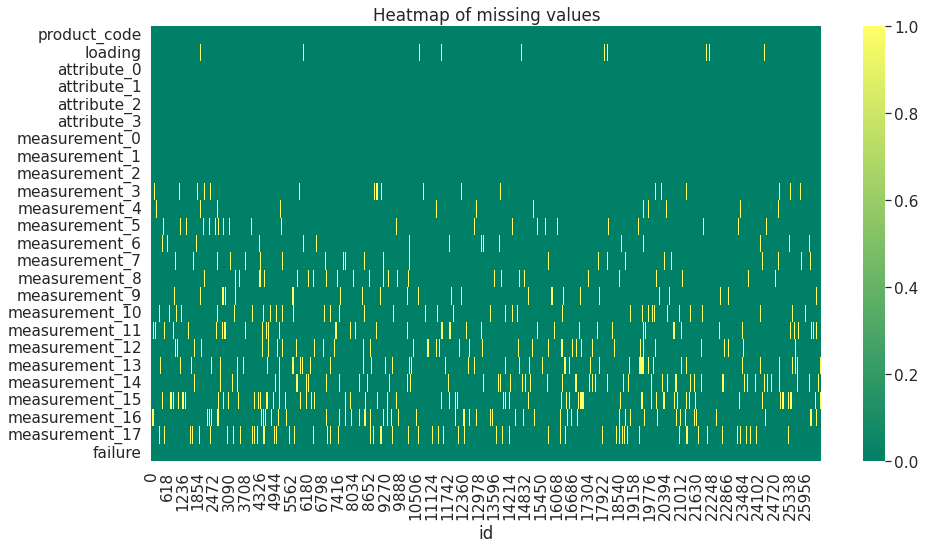

In [4]:
# Heatmap of missing values
plt.figure(figsize=(15,8))
sns.heatmap(train.isna().T, cmap='summer')
plt.title('Heatmap of missing values')

**Distribution of missing values**

Text(0.5, 1.0, 'Number of missing values for each sample')

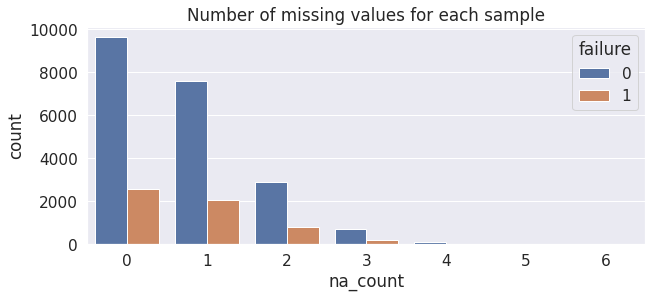

In [5]:
# Countplot of number of missing values by sample
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='failure')
plt.title('Number of missing values for each sample')

In [6]:
print('Fraction of samples with at least one missing value')
np.round((train['na_count']>0).sum()/len(train), 3)

Fraction of samples with at least one missing value


0.541

In [7]:
print('Number of failures grouped by number of missing values')
train[train['failure']==1]['na_count'].value_counts()

Number of failures grouped by number of missing values


0    2556
1    2077
2     787
3     203
4      22
5       3
6       1
Name: na_count, dtype: int64

In [8]:
print('Failure rate grouped by number of missing values')
print(train[train['failure']==1]['na_count'].value_counts()/train['na_count'].value_counts())
train.drop('na_count', axis=1, inplace=True)

Failure rate grouped by number of missing values
0    0.209801
1    0.214566
2    0.214150
3    0.225305
4    0.188034
5    0.250000
6    0.500000
Name: na_count, dtype: float64


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.3 Duplicates</b></p>
</div>

There are **no duplicated values**.

In [9]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.4 Data types</b></p>
</div>

There are **3 categorical**, **5 discrete** and **16 continuous** features. The target is **binary**.

In [10]:
train.dtypes

product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.5 Data cardinality</b></p>
</div>

The **cardinality** of categorical/discrete features is defined to be the **number of unique categories/values**. 

In [11]:
dis_cols = [col for col in train.columns if (train[col].dtypes == 'object') or (train[col].dtypes == 'int64')]
train[dis_cols].nunique()

product_code      5
attribute_0       2
attribute_1       3
attribute_2       4
attribute_3       4
measurement_0    29
measurement_1    30
measurement_2    25
failure           2
dtype: int64

# 3. EDA

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Target distribution</b></p>
</div>

The target is **moderately imbalanced**.

Text(0.5, 1.0, 'Target distribution')

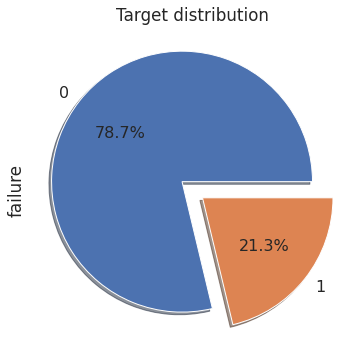

In [12]:
plt.figure(figsize=(6,6))
train['failure'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.2 Product code</b></p>
</div>

The product codes are **disjoint** between the train and test sets.

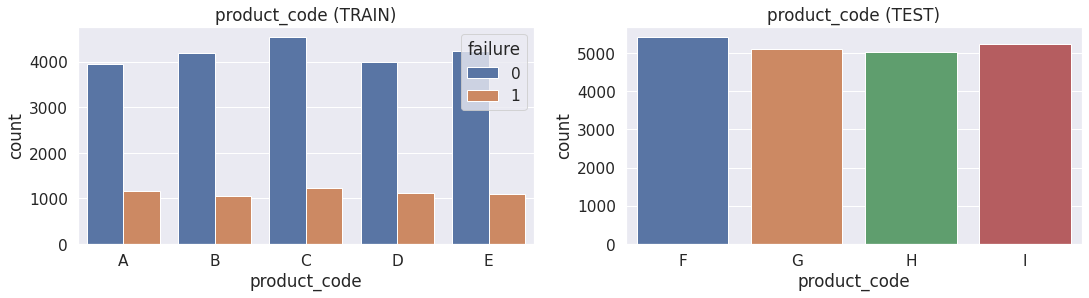

In [13]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.countplot(data=train, x='product_code', hue='failure')
plt.title('product_code (TRAIN)')

plt.subplot(1,2,2)
sns.countplot(data=test, x='product_code')
plt.title('product_code (TEST)')

plt.show()

*Insight:*
* We could try to **fill missing values** according to the product codes. 
* We could use **5 fold cross validation**, where the validation set in each fold is one of the product codes (i.e. GroupKFold).

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.3 Attributes</b></p>
</div>

* The four attributes are **uniquely determined** by the product code. 
* Some test set values **don't appear** in the train set and vice versa.

In [14]:
pd.concat([train,test])[['product_code','attribute_0','attribute_1','attribute_2','attribute_3']].drop_duplicates().set_index('product_code')

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


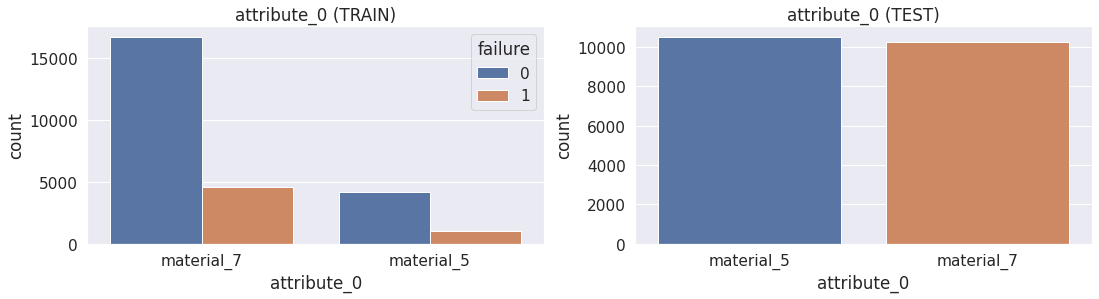

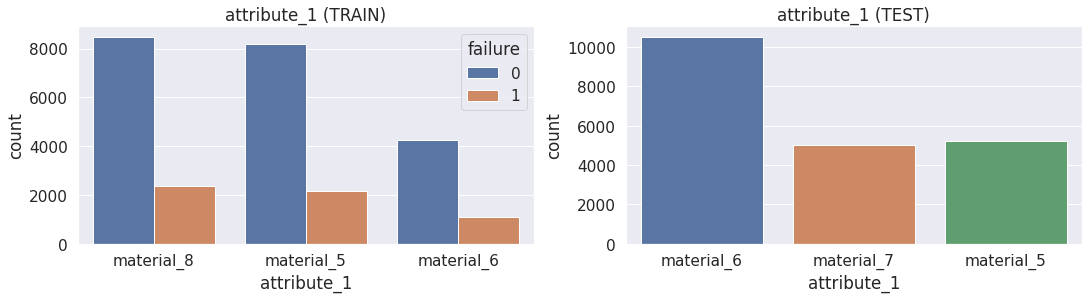

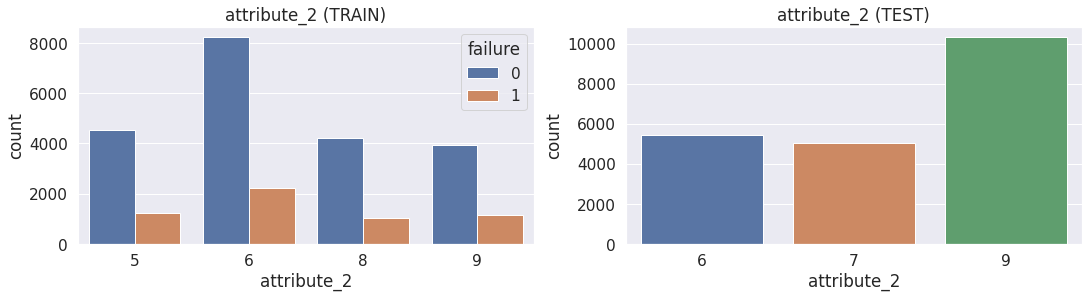

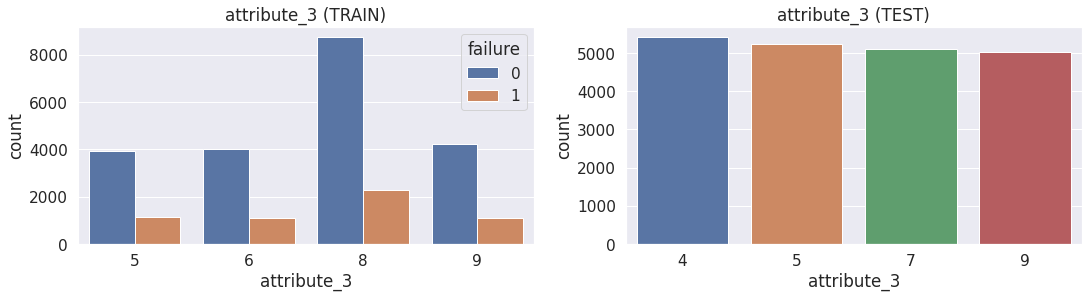

In [15]:
for i in range(4):
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.countplot(data=train, x='attribute_'+str(i), hue='failure')
    plt.title('attribute_'+str(i)+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.countplot(data=test, x='attribute_'+str(i))
    plt.title('attribute_'+str(i)+' (TEST)')

    plt.show()

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.4 Loading</b></p>
</div>

The **loading** feature measures how much **fluid** each product **absorbs** to see whether or not it fails. 

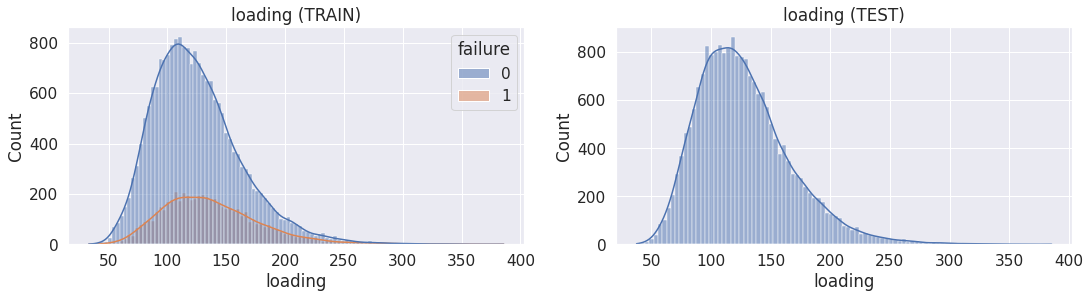

In [16]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='loading', hue='failure', kde=True)
plt.title('loading (TRAIN)')

plt.subplot(1,2,2)
sns.histplot(data=test, x='loading', kde=True)
plt.title('loading (TEST)')

plt.show()

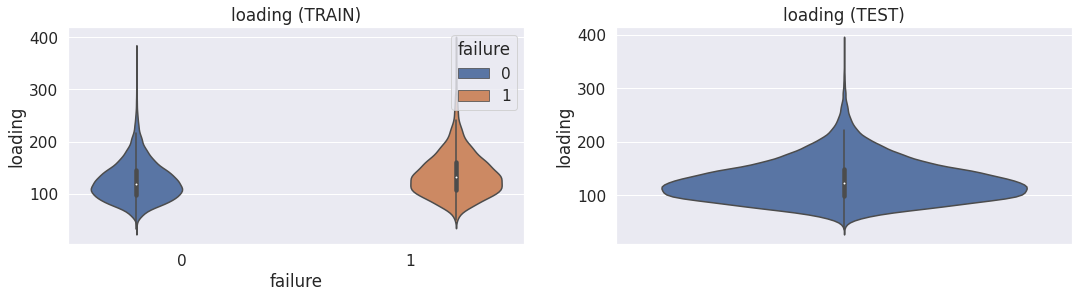

In [17]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.violinplot(data=train, x='failure', y='loading', hue='failure', kde=True)
plt.title('loading (TRAIN)')

plt.subplot(1,2,2)
sns.violinplot(data=test, y='loading', kde=True)
plt.title('loading (TEST)')

plt.show()

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.5 Measurements</b></p>
</div>

* The first 3 measurements are **discrete** and follow roughly **Poisson** distributions.
* The other 15 measurements are **continuous** and appear to follow **Gaussian** distributions.
* The features **don't separate** the target well, i.e. there is **low signal** in the data.

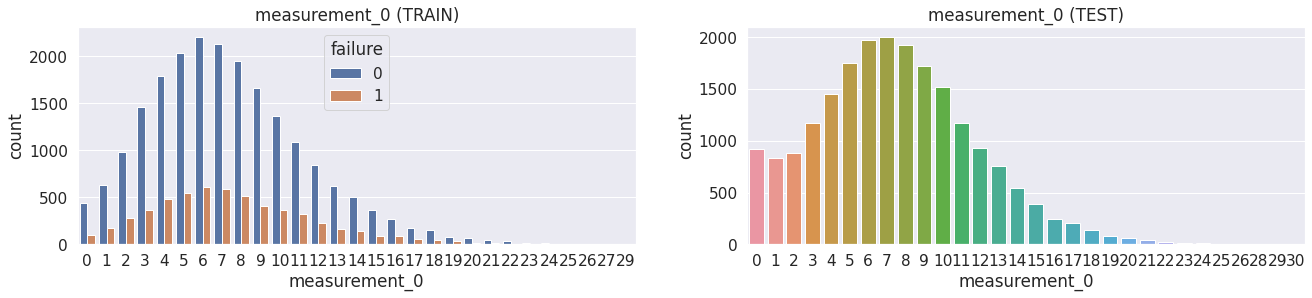

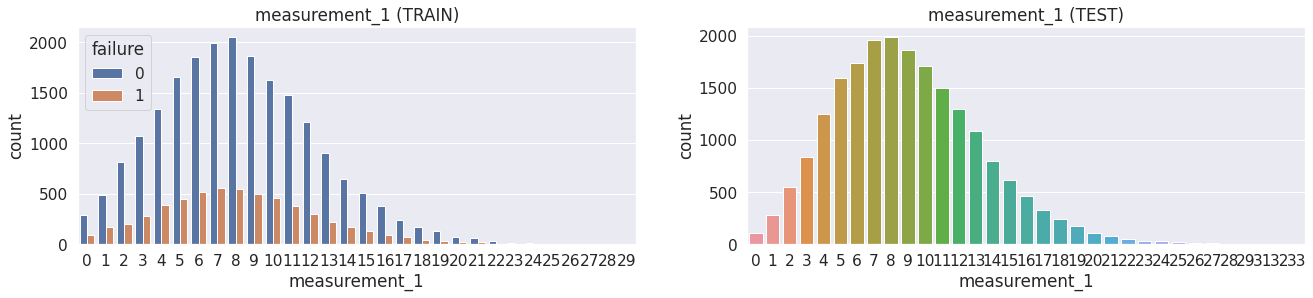

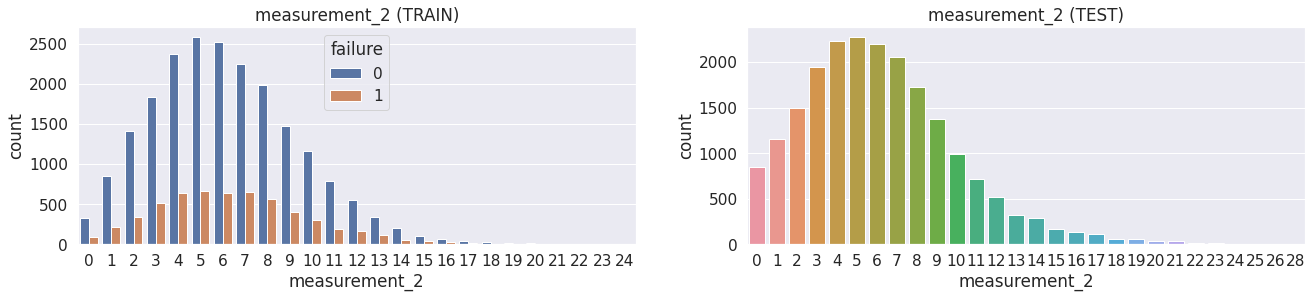

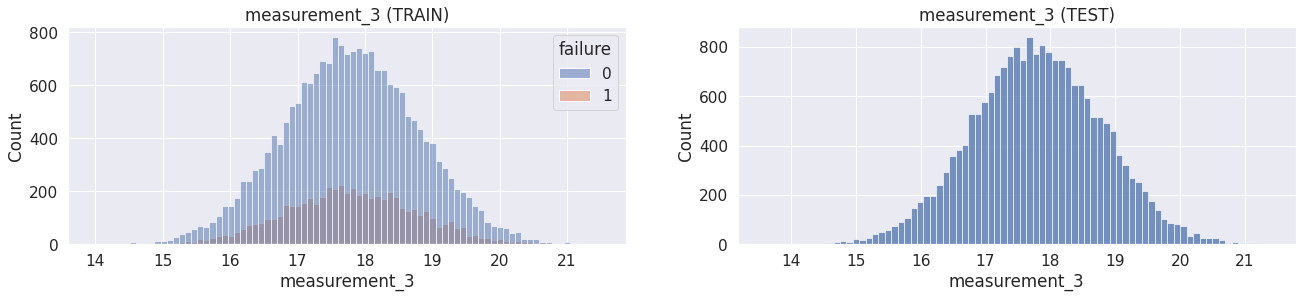

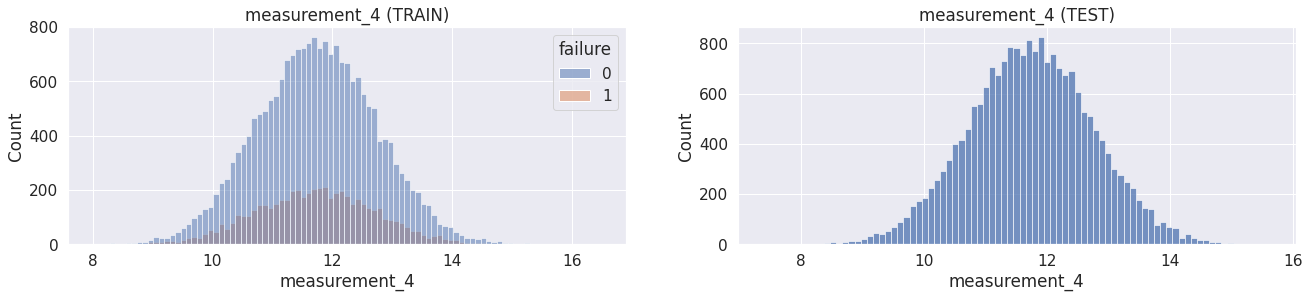

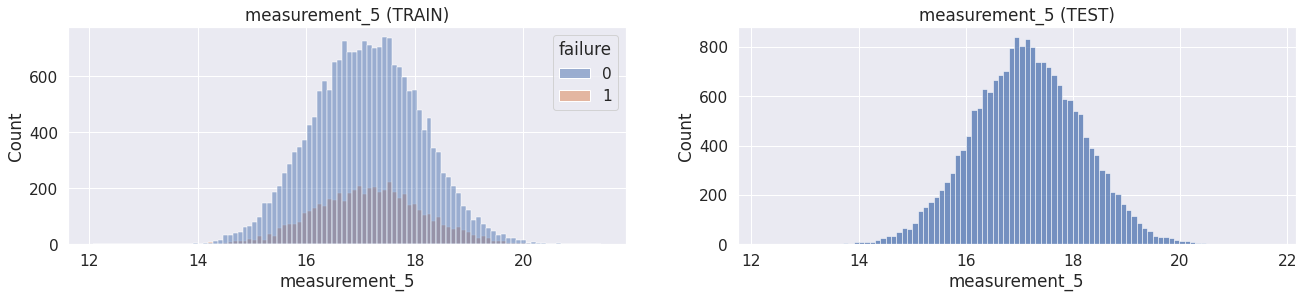

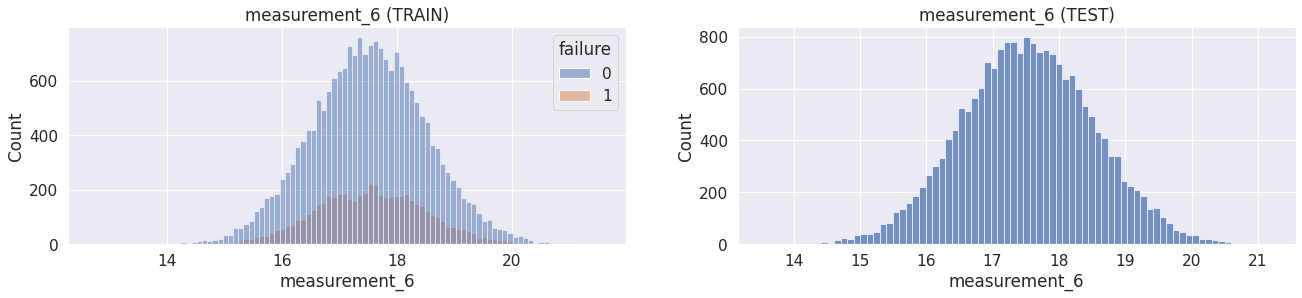

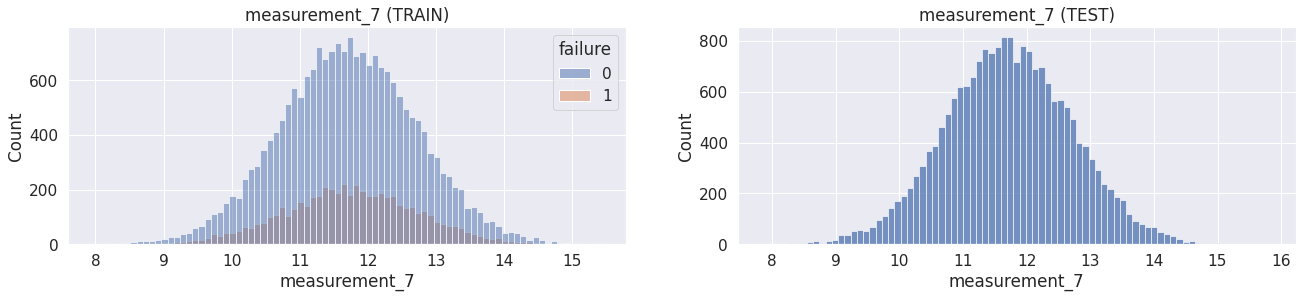

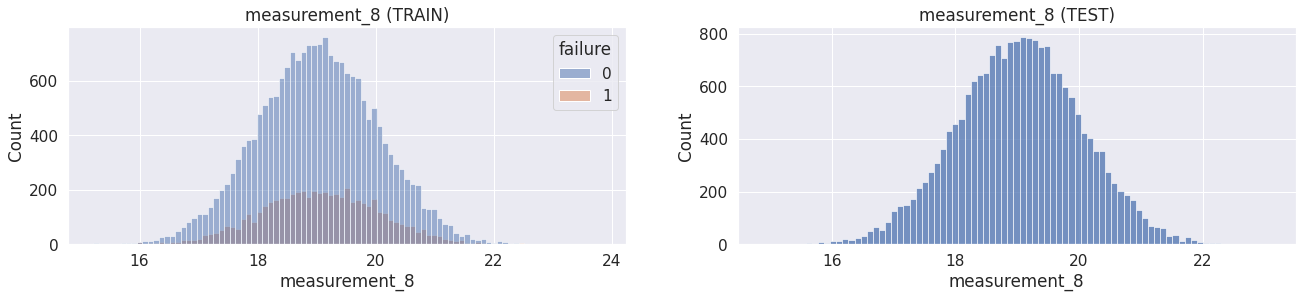

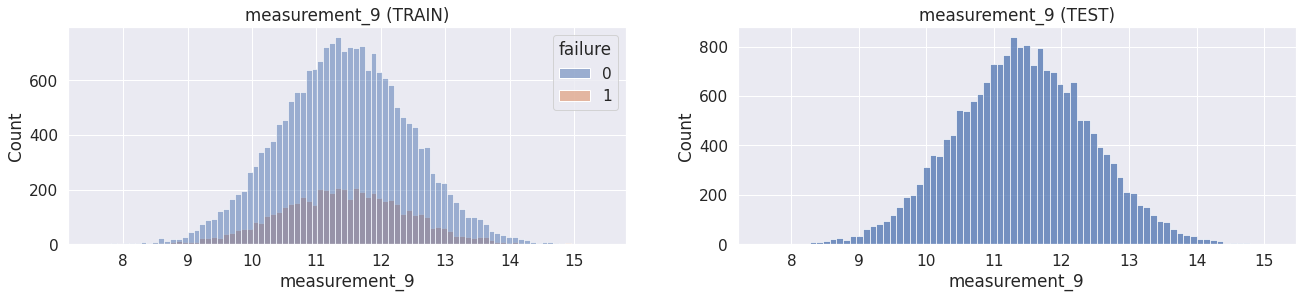

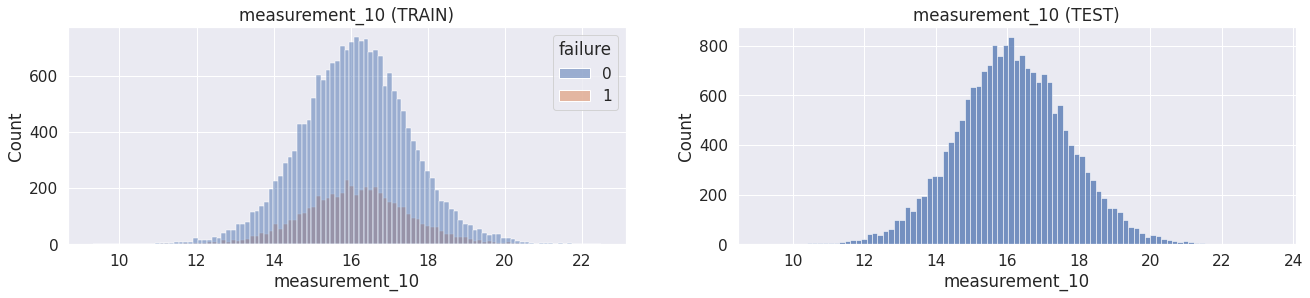

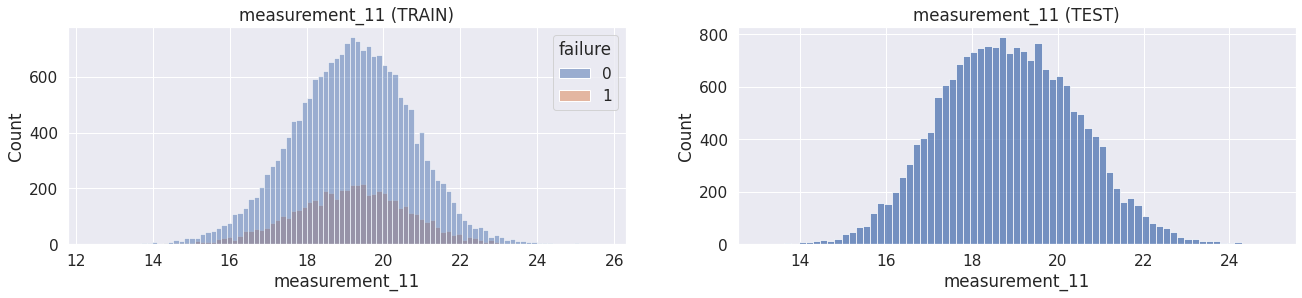

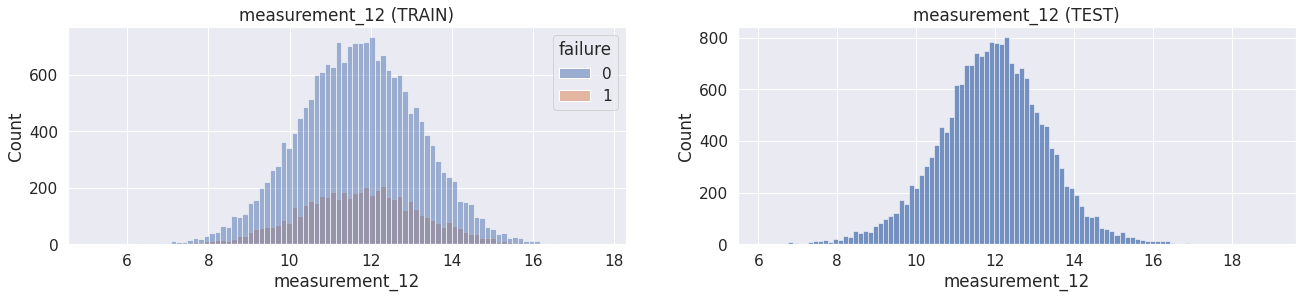

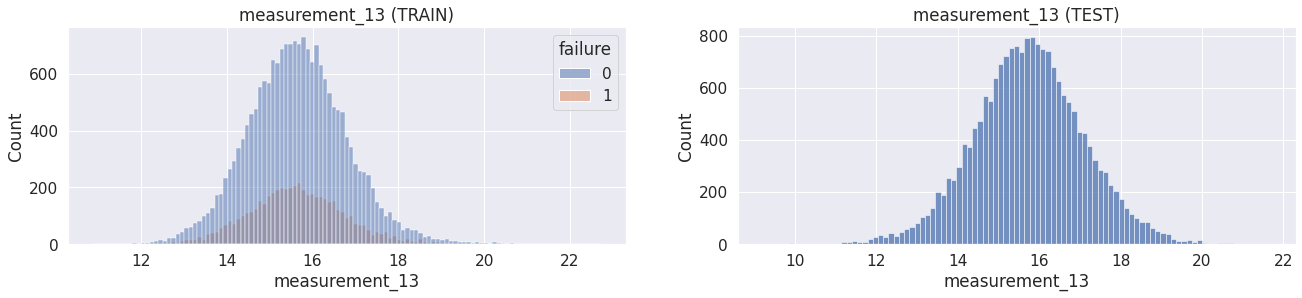

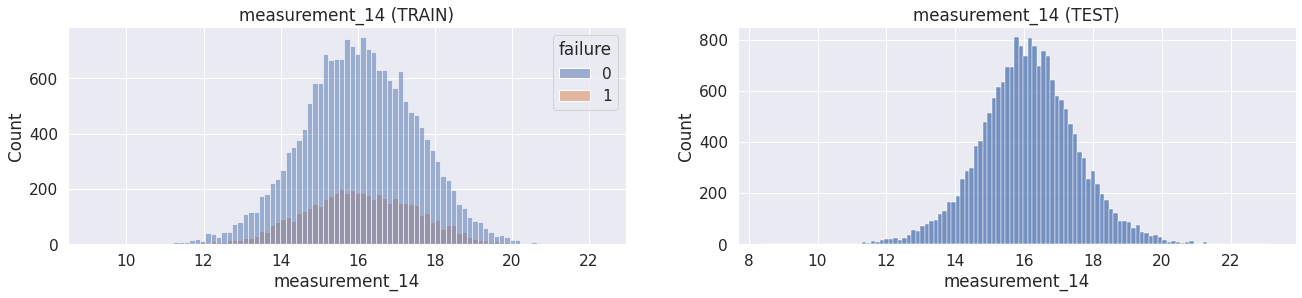

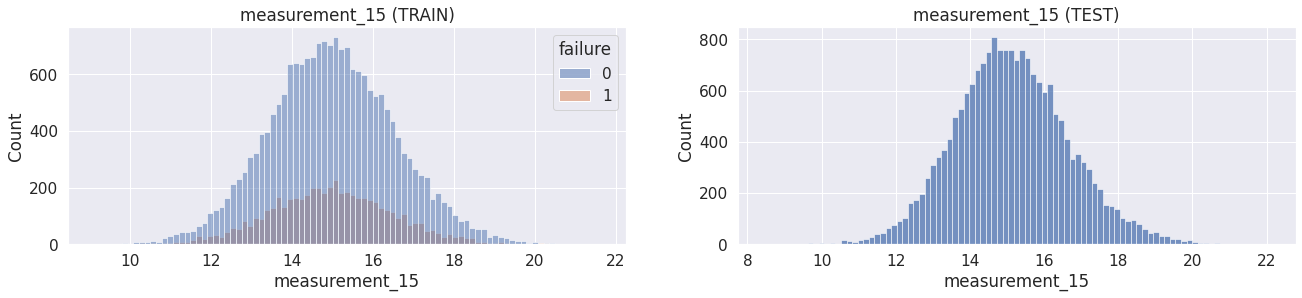

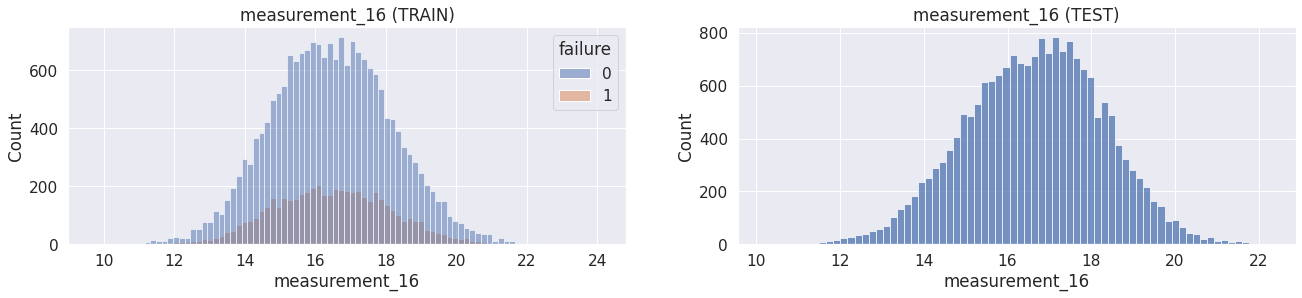

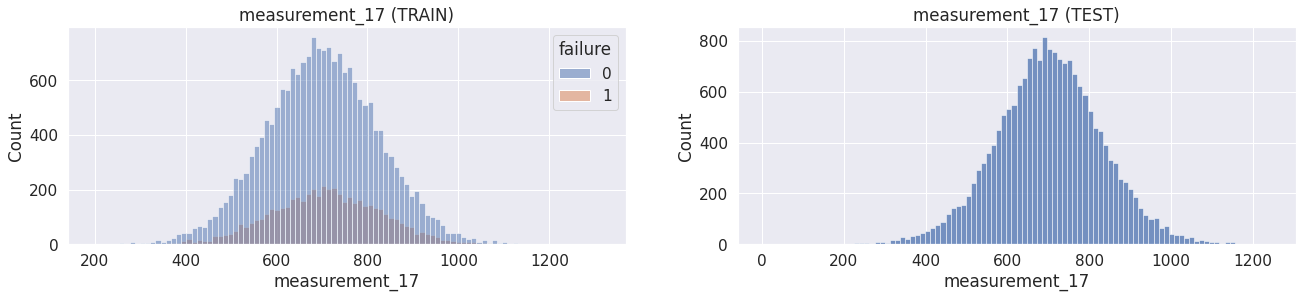

In [18]:
for i in range(3):
    plt.figure(figsize=(22,4))
    plt.subplot(1,2,1)
    sns.countplot(data=train, x='measurement_'+str(i), hue='failure')
    plt.title('measurement_'+str(i)+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.countplot(data=test, x='measurement_'+str(i))
    plt.title('measurement_'+str(i)+' (TEST)')

    plt.show()
    
for i in range(3,18):
    plt.figure(figsize=(22,4))
    plt.subplot(1,2,1)
    sns.histplot(data=train, x='measurement_'+str(i), hue='failure')
    plt.title('measurement_'+str(i)+' (TRAIN)')

    plt.subplot(1,2,2)
    sns.histplot(data=test, x='measurement_'+str(i))
    plt.title('measurement_'+str(i)+' (TEST)')

    plt.show()

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.6 Train-test distributions</b></p>
</div>

We can plot the train and test **distributions on top of each other** to see how closely they match up. This section is shamelessly stolen from AmbrosM; as the saying goes "copying is the highest form of flattery" [Reference: AmbrosM](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense).

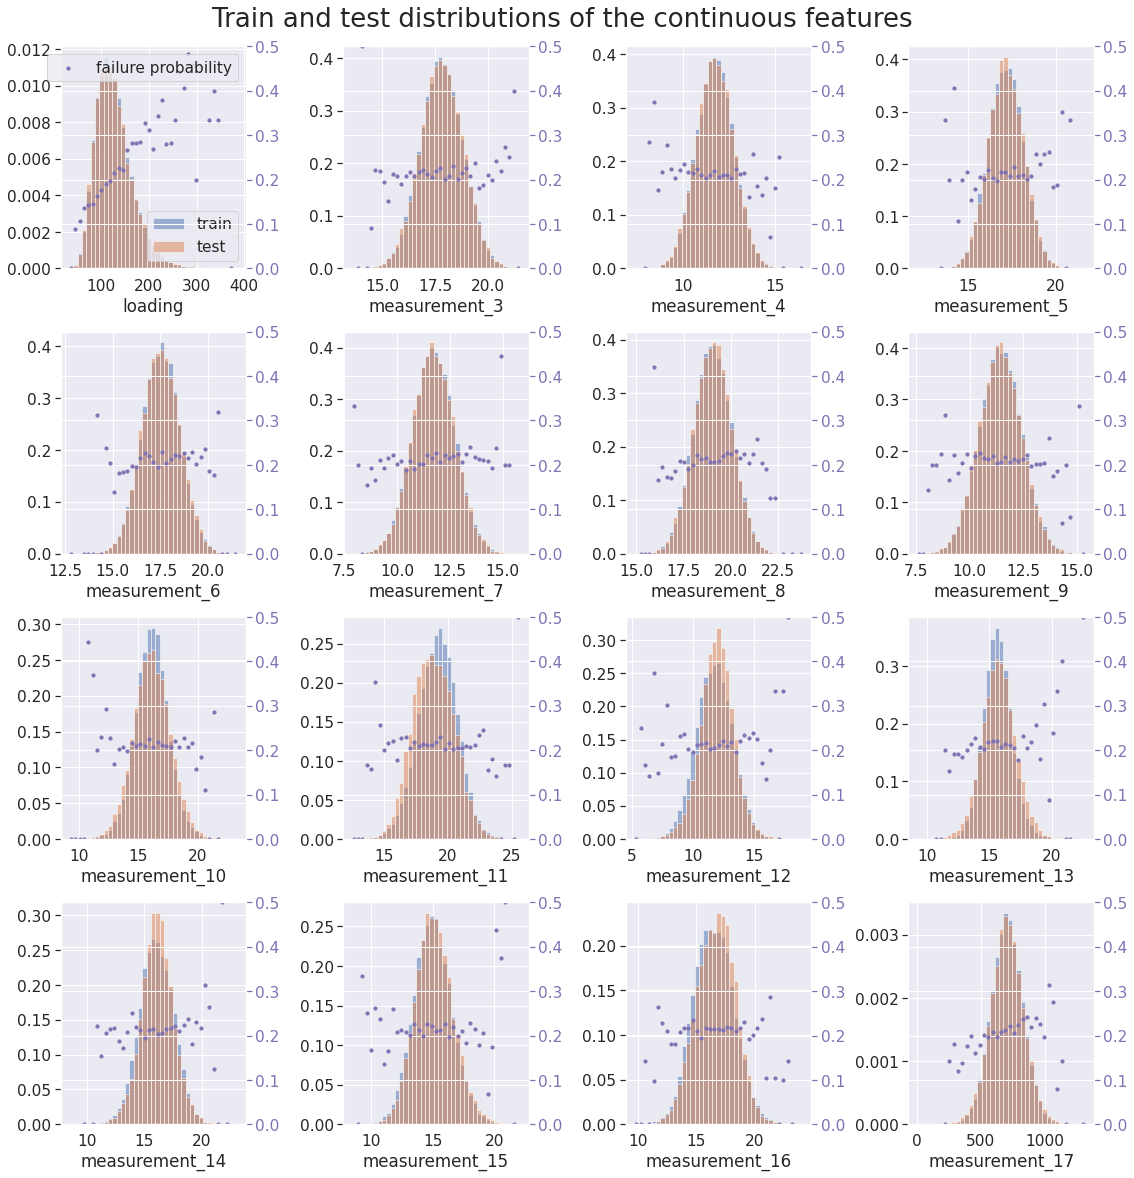

In [19]:
# From https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
float_cols = [col for col in test.columns if test[col].dtypes == 'float64']
both = pd.concat([train[test.columns], test])
_, axs = plt.subplots(4, 4, figsize=(16,16))
for f, ax in zip(float_cols, axs.ravel()):
    mi = min(train[f].min(), test[f].min())
    ma = max(train[f].max(), test[f].max())
    bins = np.linspace(mi, ma, 40)
    ax.hist(train[f], bins=bins, alpha=0.5, density=True, label='train')
    ax.hist(test[f], bins=bins, alpha=0.5, density=True, label='test')
    ax.set_xlabel(f)
    if ax == axs[0, 0]: ax.legend(loc='lower right')
        
    ax2 = ax.twinx()
    total, _ = np.histogram(train[f], bins=bins)
    failures, _ = np.histogram(train[f][train.failure == 1], bins=bins)
    with warnings.catch_warnings(): # ignore divide by zero for empty bins
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        ax2.scatter((bins[1:] + bins[:-1]) / 2, failures / total,
                    color='m', s=10, label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the continuous features', fontsize=26, y=1.02)
plt.show()

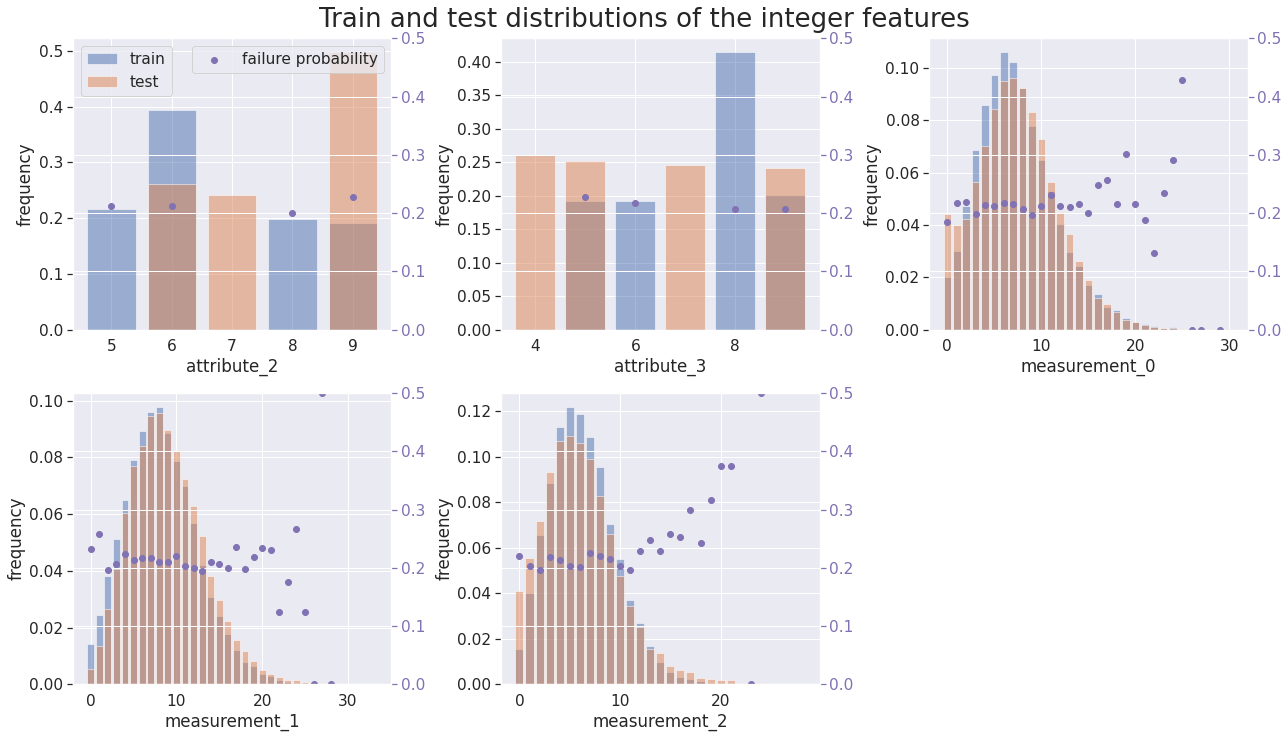

In [20]:
int_cols = [f for f in train.columns if train[f].dtype == int and f != 'failure']
_, axs = plt.subplots(2, 3, figsize=(18, 10))
for f, ax in zip(int_cols, axs.ravel()):
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train')
    temp2 = test[f].value_counts()
    ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')

    ax2 = ax.twinx()
    ax2.scatter(temp1.index, temp1['mean'],
                color='m', label='failure probability')
    ax2.set_ylim(0, 0.5)
    ax2.tick_params(axis='y', colors='m')
    if ax == axs[0, 0]: ax2.legend(loc='upper right')

axs[0, 0].legend()
axs[1, 2].axis('off')
plt.tight_layout(w_pad=1)
plt.suptitle('Train and test distributions of the integer features', fontsize=26, y=1.02)
plt.show()
del temp1, temp2

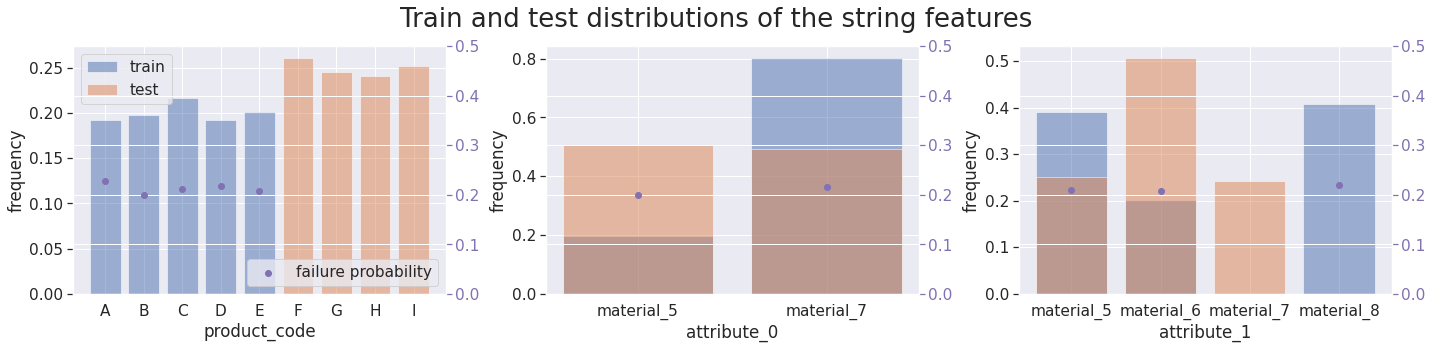

In [21]:
string_cols = [f for f in train.columns if train[f].dtype == object]
_, axs = plt.subplots(1, 3, figsize=(20, 5))
for f, ax in zip(string_cols, axs.ravel()):
    temp1 = train[f].value_counts(dropna=False, normalize=True)
    temp2 = test[f].value_counts(dropna=False, normalize=True)
    values = sorted(set(temp1.index).union(temp2.index))
    temp1 = temp1.reindex(values)
    temp2 = temp2.reindex(values)
    ax.bar(range(len(values)), temp1, alpha=0.5, label='train')
    ax.bar(range(len(values)), temp2, alpha=0.5, label='test')
    ax.set_xlabel(f)
    ax.set_ylabel('frequency')
    ax.set_xticks(range(len(values)), values)
    
    temp1 = train.failure.groupby(train[f]).agg(['mean', 'size'])
    temp1 = temp1.reindex(values)
    ax2 = ax.twinx()
    ax2.scatter(range(len(values)), temp1['mean'],
                color='m', label='failure probability')
    ax2.tick_params(axis='y', colors='m')
    ax2.set_ylim(0, 0.5)
    if ax == axs[0]: ax2.legend(loc='lower right')

axs[0].legend()
plt.suptitle('Train and test distributions of the string features', fontsize=26, y=0.96)
plt.tight_layout(w_pad=1)
plt.show()
del temp1, temp2

*Insight:*

* Most features seem to be **uncorrelated** to the target. **Loading**, **measurement 2** and **measurement 17** appear to be the **most useful**. 
* There is some **train-test drift** present, especially in measurements 0-2, 10-17 and the four attributes.

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.7 Correlations</b></p>
</div>

Positive correlations are shown in red and negative correlations in blue.

Text(0.5, 1.0, 'Correlations')

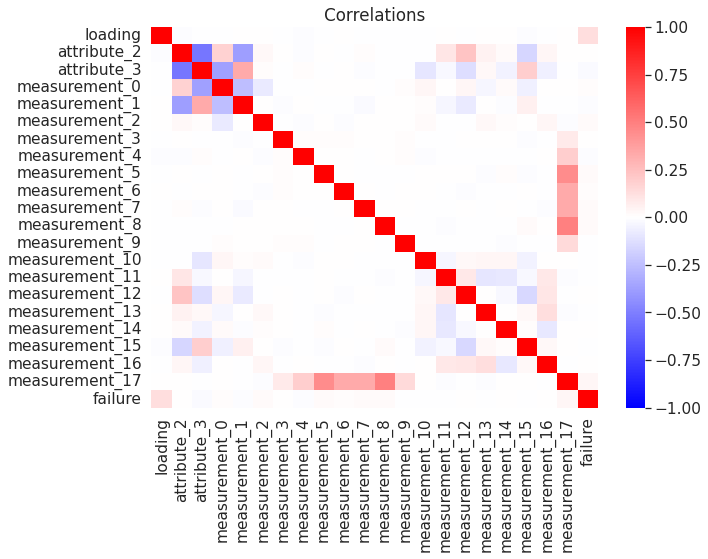

In [22]:
# Heatmap of correlations
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlations')

# 4. Competition metric

The competition metric is AUROC. To understand it, we first need to look at the ROC curve.

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 ROC</b></p>
</div>

The **Receiver Operating Characteristic** (ROC) curve measures the performance of a binary classifier. It plots the **True Positive Rate** (TPR) against the **False Positive Rate** (FPR) as the classification threshold is varied. 

In a nutshell, the closer the curve is to the **top left corner** the **better** the classifier is. It was originally developed for operators of military radar receivers in 1941, which is where the name comes from. 

<center>
<img src="https://vitalflux.com/wp-content/uploads/2020/09/Screenshot-2020-09-01-at-3.44.15-PM.png" width="450">
</center>

<br>

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.2 AUROC</b></p>
</div>

The **Area Under ROC** (AUROC aka AUC) curve is simply the **area under** the ROC curve and it measures how **good** a binary classifier is. 

$$
AUROC = \int_0^1 ROC (t) \, dt
$$

It condenses an ROC curve down to a **single number**, which makes it easier to compare the two ROC curves at the cost of losing some information. 

# 5. Preprocessing

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.1 Imputing missing values</b></p>
</div>

The **simplest** way to impute missing values is to use the **median** for continuous features and the **mode** for discrete features. This works 'ok' in practice but is usually not optimal.

Alternatively, **KNNImputer** uses the average of the k closest samples to fill missing values. This is a fast algorithm but can be sensitive to the value of k and any outliers in the dataset. 

Another approach is to use **IterativeImputer**, which models each feature with missing values as a function of other features in a round-robin fashion.

In [23]:
%%time

# Concatenate df's
data = pd.concat([train.drop(['failure'], axis=1), test], axis=0)

# Fill missing values on a by product code basis
num_cols = [col for col in train.columns[:-1] if (train[col].dtypes == 'float64') or (train[col].dtypes == 'int64')]
for code in data['product_code'].unique():
    #imputer = KNNImputer(n_neighbors = 3)
    imputer = IterativeImputer(max_iter = 8, random_state = 0, skip_complete = True, n_nearest_features = 12)
    #imputer = LGBMImputer(n_iter=50)
    data.loc[data['product_code']==code,num_cols] = imputer.fit_transform(data.loc[data['product_code']==code,num_cols])

CPU times: user 26.8 s, sys: 30.4 s, total: 57.2 s
Wall time: 14.6 s


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.2 Categorical encoding</b></p>
</div>

The most common approach to dealing with categorical data is to either use **LabelEncoder** (0, 1, 2, ...) or **OneHotEncoder** (elementary vectors).

Label encoding replaces each category by an integer 0, 1, 2, etc, whilst one hot encoding converts in category into a new column filled with 0's except when samples fall to that category which we denote by 1.

<center>
<img src="https://miro.medium.com/max/1200/0*T5jaa2othYfXZX9W." width="600">
</center>

In [24]:
'''
# Label encoding
cat_cols = [col for col in train.columns[:-1] if train[col].dtypes == 'object']
for col in cat_cols:
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col])
'''

# One-hot encoding
encoded_columns = ['attribute_0', 'attribute_1']
for col in encoded_columns:
    tempdf = pd.get_dummies(data[col], prefix = col)
    data = pd.merge(left = data, right = tempdf, left_index = True, right_index = True)
data = data.drop(encoded_columns, axis = 1)

# Drop one of the binary one-hot columns - cf 'dummy variable trap'
data.drop('attribute_0_material_5', axis=1, inplace=True)

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.3 Feature engineering</b></p>
</div>

**Better features** make **better models**. 

In [25]:
# From https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/342319
data['measurement_3_na'] = data['measurement_3'].isna().astype(int)
data['measurement_5_na'] = data['measurement_5'].isna().astype(int)

# From https://www.kaggle.com/code/desalegngeb/tps08-logisticregression-and-some-fe/notebook?scriptVersionId=102685100
data['attribute_2*3'] = data['attribute_2'] * data['attribute_3']

# From https://www.kaggle.com/code/heyspaceturtle/feature-selection-is-all-u-need-2
meas_gr1_cols = [f"measurement_{i:d}" for i in list(range(3, 5)) + list(range(9, 17))]
data['meas_gr1_avg'] = np.mean(data[meas_gr1_cols], axis=1)
data['meas_gr1_std'] = np.std(data[meas_gr1_cols], axis=1)
meas_gr2_cols = [f"measurement_{i:d}" for i in list(range(5, 9))]
data['meas_gr2_avg'] = np.mean(data[meas_gr2_cols], axis=1)

# Re-split
train_split = data.iloc[:train.shape[0],:].copy()
test_split = data.iloc[train.shape[0]:,:].copy()

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.4 Scaling</b></p>
</div>

**Scaling** makes the data **more normally distributed** and typically helps classification algorithms **learn parameters faster**. 


<center>
<img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/09/image-47.png" width="400">
</center>

There are several ways to do this, e.g.

* *StandardScaler*: scales each column independently to have mean 0 and standard deviation 1, by subtracting by the column **mean** and dividing by the column **standard deviation**.
* *RobustScaler*: does the same as above but uses statistics that are **robust to outliers**, i.e. it subtracts by the **median** and divides by the **interquartile range**. 
* *PowerTransformer*: makes columns more gaussian like by **stabilising variance** and **minising skew**. 

In [26]:
# Scaling
scale_feats = [col for col in train_split.columns if train_split[col].dtypes == 'float64']
scaler = StandardScaler()
#scaler = PowerTransformer()

train_scaled = train_split.copy()
test_scaled = test_split.copy()
train_scaled[scale_feats] = scaler.fit_transform(train_split[scale_feats])
test_scaled[scale_feats] = scaler.transform(test_split[scale_feats])

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.5 Feature selection</b></p>
</div>

The aim of feature selection is to **drop redundant features** to reduce the chance of our models overfitting to noise. There are several ways to do this, e.g. by using metrics like **correlation coeffecient**, **Mutual Information**, **Fisher Information**, etc. This time we'll use Fisher Information, which tells us how much information about an unknown parameter we can get from a sample.

In [27]:
# From https://www.kaggle.com/code/heyspaceturtle/feature-selection-is-all-u-need-2
def FisherScore(bt, y_train, predictors):
    """
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = y_train.unique()
    
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[y_train == target_var_val[0], v]) - np.mean(bt.loc[y_train == target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[y_train == target_var_val[0], v]) + np.var(bt.loc[y_train == target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

# Calculate Fisher Score for all variables
fs = FisherScore(train_scaled, train['failure'], train_scaled.drop('product_code', axis=1).columns)
fs_df = pd.DataFrame({"predictor":train_scaled.drop('product_code', axis=1).columns, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False).reset_index(drop=True)
fs_df.head(10)

,predictor,fisherscore
0,loading,0.217018
1,meas_gr2_avg,0.057522
2,measurement_17,0.055936
3,attribute_3,0.033091
4,measurement_5,0.030981
5,measurement_8,0.030665
6,measurement_7,0.029059
7,measurement_2,0.027061
8,attribute_2*3,0.026810
9,attribute_0_material_7,0.025840


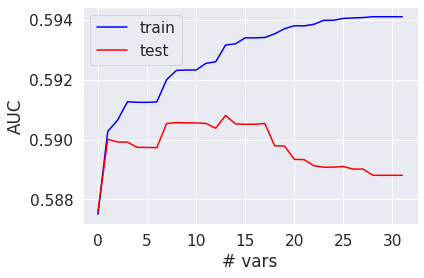

In [28]:
# Check how AUC changes when adding more variables sorted by fisher score importance
fs_scores = []
top_n_vars = len(fs_df)
for i in range(1, top_n_vars+1):
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression(max_iter = 200, C=0.05, penalty='l1', solver='liblinear')
    fs_scores.append(cross_validate(clf, train_scaled[top_n_predictors], train['failure'], groups=train_scaled['product_code'],
                                    scoring='roc_auc', cv=GroupKFold(n_splits=5), verbose=0, n_jobs=-1, return_train_score=True))

# Plot
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [29]:
# Select features
keep_feats = fs_df['predictor'][:14]
train_final = train_scaled[keep_feats]
test_final = test_scaled[keep_feats]

# 6. Modelling

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>6.1 Training</b></p>
</div>

* We use a **Logistic Regression model** since others have found this to be performing the best on this dataset. 
* We use **5 fold cross validation** grouped by product_code. 
* Hyperparameters are tuned using **grid search**.

In [30]:
%%time
# From https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
auc_list = []
test_pred_list = []
importance_list = []
kf = GroupKFold(n_splits=5)   # grouped by product_code
for fold, (idx_tr, idx_va) in enumerate(kf.split(X=train, y=train['failure'], groups=train['product_code'])):
    X_tr = train_final.iloc[idx_tr]
    X_va = train_final.iloc[idx_va]
    y_tr = train.loc[idx_tr,'failure']
    y_va = train.loc[idx_va,'failure']
    
    # LR with GridSearch
    #model = LogisticRegression(max_iter=200 , solver='liblinear', random_state=0)
    #param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], 'penalty':['l2']}
    #clf = GridSearchCV(model, param_grid, cv = 5, verbose = 0)
    
    clf = LogisticRegression(max_iter = 200, C=0.05, penalty='l1', solver='liblinear')
    
    clf.fit(X_tr, y_tr)
    importance_list.append(clf.coef_.ravel())
    
    # Validate model
    va_preds = clf.predict_proba(X_va)[:,1]
    score = roc_auc_score(y_va, va_preds)
    print(f"Fold {fold}: auc = {score:.5f}")
    auc_list.append(score)
    
    # Test set predictions
    test_pred_list.append(clf.predict_proba(test_final)[:,1])
    
print(f'Average auc = {sum(auc_list) / len(auc_list):.5f}')
print('')
preds = sum(test_pred_list)/len(test_pred_list)

Fold 0: auc = 0.58566
Fold 1: auc = 0.58610
Fold 2: auc = 0.59248
Fold 3: auc = 0.59813
Fold 4: auc = 0.59166
Average auc = 0.59081

CPU times: user 1.71 s, sys: 1.03 s, total: 2.74 s
Wall time: 1.15 s


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>6.2 Feature importances</b></p>
</div>

**Feature importance** is a way to analyse which features were the **most useful** for the model. For many industries it is very important that machine learning models are **explainable**. For logistic regression, the importances are are simply given by the **feature weights**. 

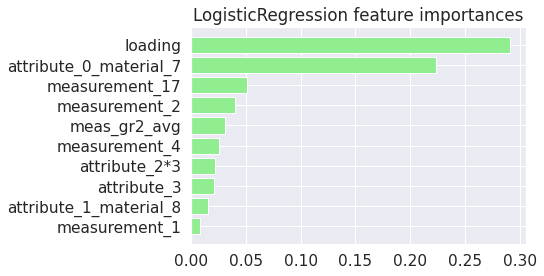

In [31]:
# From https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
# Show feature importances
importance_df = pd.DataFrame(np.array(importance_list).T, index=train_final.columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = train_final.columns
importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(10)
plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
plt.gca().invert_yaxis()
plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances')
plt.show()

# 7. Submission

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>7.1 Ensemble</b></p>
</div>

In a [discussion post by Lennart Haupts](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/342403) strong evidence was presented that the **public leaderboard** (LB) is made up of data corresponding to **product_code F** only (about 26% of the test set), meaning that the **private LB** will be made up of the other **product_codes G, H, I**.

Let's take a submission that scores highly on the public LB and our one that scores highly on CV. We'll combine them by separately **ranking** the probabilities and **scaling** them to be between 0 and 1. Then we can **concatenate** the two submissions as they are on the same scale. ([reference](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/343202))

In [32]:
# Highest scoring submission on LB (atm)
high_sub = pd.read_csv('../input/tps-aug-22-highest-scoring-public-lb-submission/submission.csv')

# My predictions
submission = pd.DataFrame({'id': test.index,'failure': preds})

# Extract indexes
code_F = test[test['product_code']=='F'].index
code_GHI = test[test['product_code']!='F'].index

# Rank and scale
high_sub.loc[high_sub['id'].isin(code_F),'failure'] = high_sub.loc[high_sub['id'].isin(code_F),'failure'].rank() / high_sub.loc[high_sub['id'].isin(code_F),'failure'].rank().max()
submission.loc[submission['id'].isin(code_GHI),'failure'] = submission.loc[submission['id'].isin(code_GHI),'failure'].rank() / submission.loc[submission['id'].isin(code_GHI),'failure'].rank().max()

# Combine predictions
submission['failure'] = pd.concat([high_sub.loc[high_sub['id'].isin(code_F),'failure'], submission.loc[submission['id'].isin(code_GHI),'failure']])

<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>7.2 Save to csv</b></p>
</div>

In [33]:
submission.to_csv('submission.csv', index=False)
submission.head()

,id,failure
0,26570,0.389524
1,26571,0.177425
2,26572,0.277020
3,26573,0.296201
4,26574,0.966986


<div style="color:white;display:fill;
            background-color:#6b1515;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>7.3 Probability distribution</b></p>
</div>

Text(0.5, 1.0, 'Predicted probabilities')

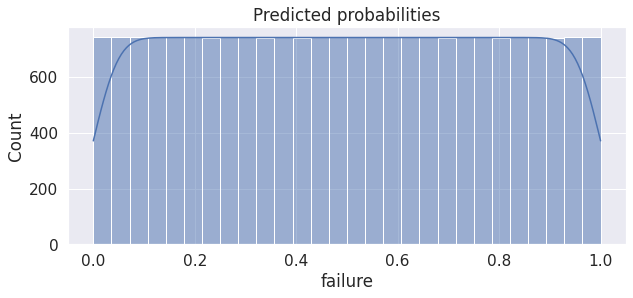

In [34]:
plt.figure(figsize=(10,4))
sns.histplot(submission['failure'], kde=True)
plt.title('Predicted probabilities')

# 8. References

* [TPS AUG - Simple Baseline](https://www.kaggle.com/code/thedevastator/tps-aug-simple-baseline/notebook?scriptVersionId=102469592) by [The Devastator](https://www.kaggle.com/thedevastator).
* [TPSAUG22 EDA which makes sense](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense) by [AmbrosM](https://www.kaggle.com/ambrosm).
* [TPS 08.22 | Logistic Regression](https://www.kaggle.com/code/kostiantynlavronenko/tps-08-22-logistic-regression) by [Kostiantyn Lavronenko](https://www.kaggle.com/kostiantynlavronenko).
* [TPS08: LogisticRegression, kNN and ExtraTrees](https://www.kaggle.com/code/desalegngeb/tps08-logisticregression-knn-and-extratrees/notebook?scriptVersionId=102603134) by [des.](https://www.kaggle.com/desalegngeb)
* [The area under the ROC curve. AUROC.](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/341037) by [Marília Prata](https://www.kaggle.com/mpwolke).
* [feature selection is all u need 2](https://www.kaggle.com/code/heyspaceturtle/feature-selection-is-all-u-need-2) by [Fernando Delgado
](https://www.kaggle.com/heyspaceturtle).
* [TPS - Aug 2022](https://www.kaggle.com/code/sfktrkl/tps-aug-2022/notebook) by [Şafak Türkeli](https://www.kaggle.com/sfktrkl).
* [TPS-Aug22 LB 0.59013](https://www.kaggle.com/code/takanashihumbert/tps-aug22-lb-0-59013) by [Sawaimilert](https://www.kaggle.com/takanashihumbert).